# Imports

In [3]:
!git clone https://github.com/MrARVO/GraphZ.git

Cloning into 'GraphZ'...
remote: Enumerating objects: 1144, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1144 (delta 1), reused 5 (delta 1), pack-reused 1139
Receiving objects: 100% (1144/1144), 1.34 GiB | 29.93 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (1135/1135), done.


In [4]:
!git clone https://github.com/Nazar1997/Sparse_vector.git sparse_vector

Cloning into 'sparse_vector'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 81 (delta 37), reused 62 (delta 18), pack-reused 0
Unpacking objects: 100% (81/81), 17.52 KiB | 779.00 KiB/s, done.


In [5]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 753.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:0000:0100:01


In [6]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from sparse_vector.sparse_vector import SparseVector

In [7]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [8]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('GraphZ/data/hg19_features/')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features if (i.split('_')[0] in groups)]

In [9]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'GraphZ/data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"GraphZ/data/hg19_dna/{file}") for file in files])

In [10]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
ZDNA = load('GraphZ/data/hg19_zdna/ZDNA.pkl')

DNA_features = {feture: load(f'GraphZ/data/hg19_features/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

# Data selection

In [11]:
np.random.seed(42)
class GraphDataset(Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels, intervals,
                 transform=None, pre_transform=None, pre_filter=None):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels = labels
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

        self.ei = [[],[]]
        for i in range(1000-1):
            self.ei[0].append(i)
            self.ei[0].append(i+1)
            self.ei[1].append(i+1)
            self.ei[1].append(i)
        super().__init__(transform, pre_transform, pre_filter)

    def len(self):
        return len(self.intervals)

    def get(self, idx):
        interval = self.intervals[idx]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        X = torch.tensor(X, dtype=torch.float)

        edge_index = torch.tensor(np.array(self.ei), dtype=torch.long)

        y = self.labels[interval[0]][interval[1]: interval[2]]
        y = torch.tensor(y, dtype=torch.int64)

        return Data(x=X, edge_index=edge_index, y=y)


In [12]:
width = 1000

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████| 16/16 [00:00<00:00, 17890.93it/s]


In [13]:
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

In [14]:
np.random.seed(42)
train_dataset = GraphDataset(chrom_names, feature_names,
                            DNA, DNA_features,
                            ZDNA, train_intervals)

test_dataset = GraphDataset(chrom_names, feature_names,
                           DNA, DNA_features,
                           ZDNA, test_intervals)

In [15]:
np.random.seed(42)
params = {'batch_size':16,
          'num_workers':4,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

# LSTM model

In [16]:
class DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(1058, 500, 2, bidirectional=True)
        self.seq = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(2 * 500, 500),
                    nn.Sigmoid(),
                    nn.Dropout(0.5),
                    nn.Linear(500, 2)
        )
    
    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

In [15]:
class DeepZBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(1058, 500, 2, bidirectional=True)
        self.seq = nn.Sequential(
                    nn.BatchNorm1d(2 * 500),
                    nn.Dropout(0.5),
                    nn.Linear(2 * 500, 500),
                    nn.Sigmoid(),
                    nn.BatchNorm1d(500), 
                    nn.Dropout(0.5),
                    nn.Linear(500, 2)
        )
    
    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

In [16]:
class DeepZBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(1058, 500, 2, bidirectional=True)
        self.seq = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(2 * 500, 600),
                    nn.Sigmoid(),
                    nn.Dropout(0.5),
                    nn.Linear(600, 400),
                    nn.Sigmoid(),
                    nn.Dropout(0.5),
                    nn.Linear(400, 2)
        )
    
    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

# Train and test

In [17]:
np.random.seed(42)
def loss_func(output, y_batch):
    return torch.nn.NLLLoss(weight=torch.tensor([1.0, 25.0]).cuda())(output, y_batch)


def train_epoch(model, optimizer):
    roc_auc_log, f1_log, acc_log, loss_log = [], [], [], []
    model.train()

    for dt in loader_train:
        x, edge, y = dt.x.cuda(), dt.edge_index.cuda(), dt.y.cuda().long()

        optimizer.zero_grad()

        output = model(x)
        pred = torch.argmax(output, dim=1)
        y_pred = nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        roc_auc_log.append(roc_auc)

        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, f1_log, acc_log, loss_log


def test(model):
    np.random.seed(42)
    roc_auc_log, f1_log, acc_log, loss_log = [], [], [], []
    model.eval()

    means = []
    for dt in loader_test:
        x, edge, y = dt.x.cuda(), dt.edge_index.cuda(), dt.y.cuda().long()

        output = model(x)
        means.append(y.sum().cpu() / (1.0 * y.shape[0]))
        pred = torch.argmax(output, dim=1)

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        roc_auc_log.append(roc_auc)

        f1 = f1_score(y.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten())
        if f1 == 0.0 and torch.all(y == 0) and torch.all(pred == 0):
            print("all zeros")
        else:
            f1_log.append(f1)

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output, y)
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, f1_log, acc_log, loss_log


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    np.random.seed(42)
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)

    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)

    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize),
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')

    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2),
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def train(model, opt, n_epochs):
    np.random.seed(42)
    train_auc_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], []
    val_auc_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_auc, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_f1, val_acc, val_loss = test(model)

        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))


        clear_output()
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss))
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss))
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))


    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))

    return val_auc_log, val_f1_log, val_acc_log, val_loss_log

In [20]:
torch.cuda.empty_cache()

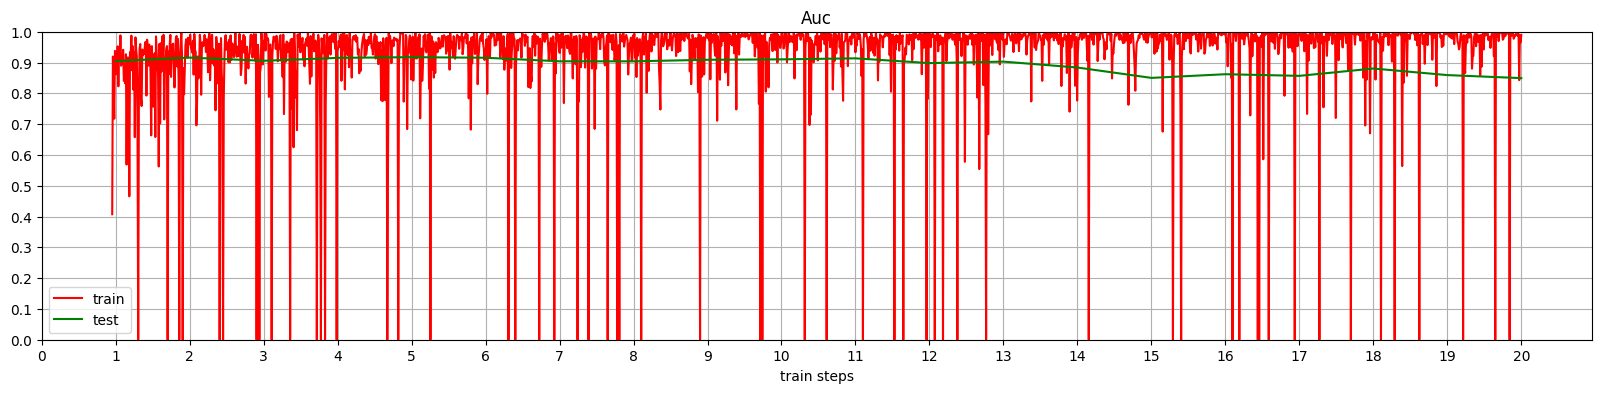

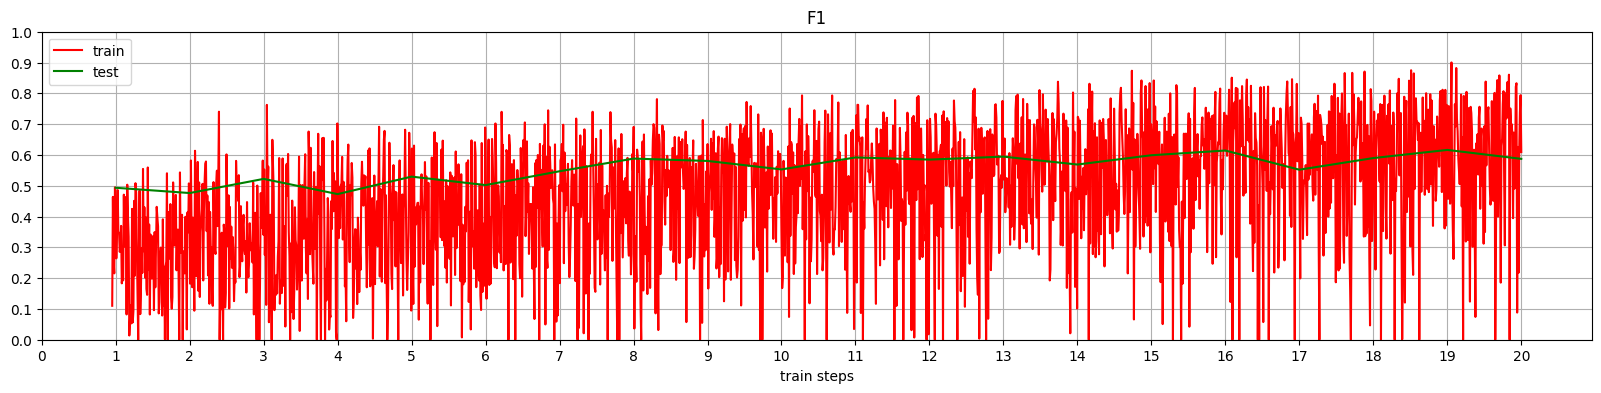

Epoch 20: ROC-AUC = 84.94%
Epoch 20: F1-score = 0.587
Final ROC-AUC = 84.94%
Final F1-score = 0.587
CPU times: user 1h 25min 50s, sys: 26min 17s, total: 1h 52min 7s
Wall time: 1h 52min 49s


In [21]:
%%time
np.random.seed(42)
set_random_seed(42)
model = DeepZ()
model = model.cuda()

opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_f1_log, val_acc_log, val_loss_log = train(model, opt, 20)

In [22]:
print("Epoch {} Max ROC-AUC: {:.4f}, F1-score: {:.4f}".format(np.argmax(val_auc_log),val_auc_log[np.argmax(val_auc_log)], val_f1_log[np.argmax(val_auc_log)]))
print("Epoch {} ROC-AUC: {:.4f}, Max F1-score: {:.4f}".format(np.argmax(val_f1_log),val_auc_log[np.argmax(val_f1_log)], val_f1_log[np.argmax(val_f1_log)]))

Epoch 4 Max ROC-AUC: 0.9174, F1-score: 0.5295
Epoch 18 ROC-AUC: 0.8592, Max F1-score: 0.6162


In [23]:
torch.cuda.empty_cache()

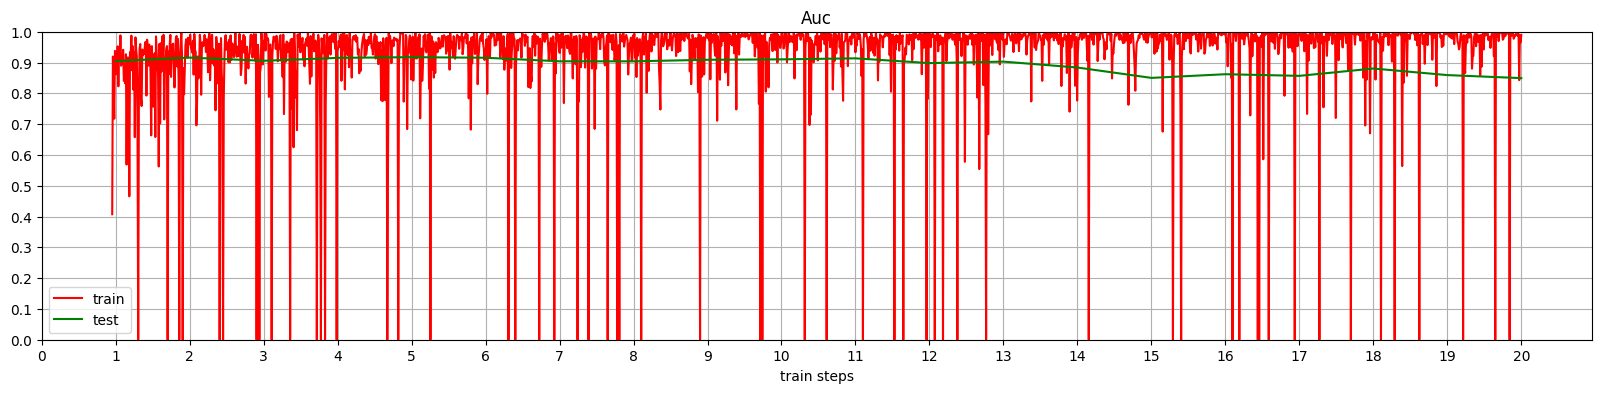

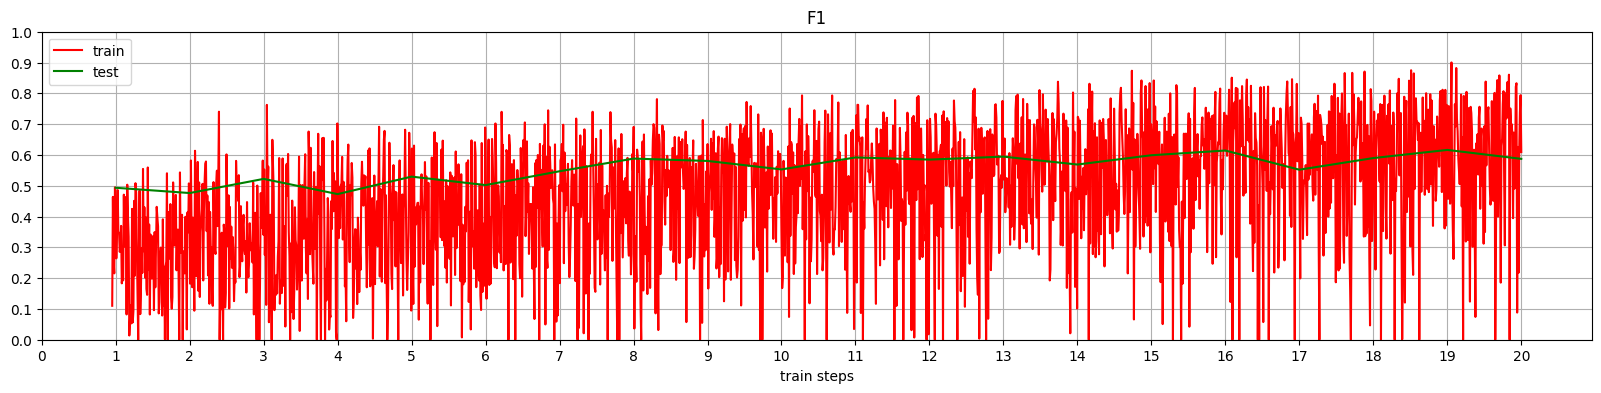

Epoch 20: ROC-AUC = 84.94%
Epoch 20: F1-score = 0.587
Final ROC-AUC = 84.94%
Final F1-score = 0.587
CPU times: user 1h 25min 30s, sys: 25min 44s, total: 1h 51min 14s
Wall time: 1h 51min 59s


In [24]:
%%time
np.random.seed(42)
set_random_seed(42)
model =  DeepZBatchNorm()
model = model.cuda()

opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_f1_log, val_acc_log, val_loss_log = train(model, opt, 20)

In [25]:
print("Epoch {} Max ROC-AUC: {:.4f}, F1-score: {:.4f}".format(np.argmax(val_auc_log),val_auc_log[np.argmax(val_auc_log)], val_f1_log[np.argmax(val_auc_log)]))
print("Epoch {} ROC-AUC: {:.4f}, Max F1-score: {:.4f}".format(np.argmax(val_f1_log),val_auc_log[np.argmax(val_f1_log)], val_f1_log[np.argmax(val_f1_log)]))

Epoch 4 Max ROC-AUC: 0.9174, F1-score: 0.5295
Epoch 18 ROC-AUC: 0.8592, Max F1-score: 0.6162


In [26]:
torch.cuda.empty_cache()

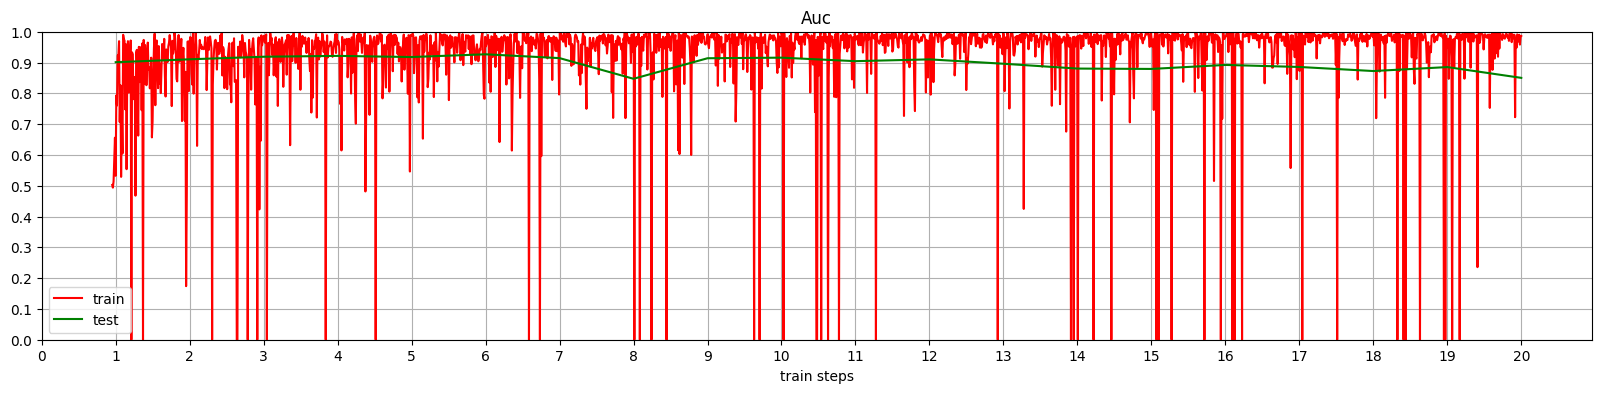

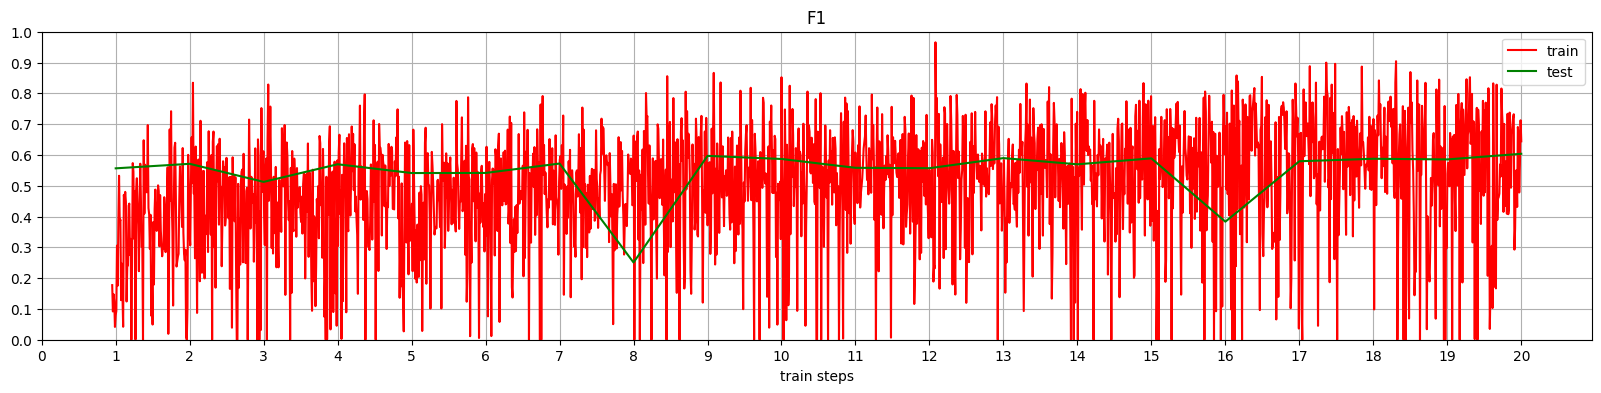

Epoch 20: ROC-AUC = 85.02%
Epoch 20: F1-score = 0.604
Final ROC-AUC = 85.02%
Final F1-score = 0.604
CPU times: user 1h 25min 28s, sys: 25min 47s, total: 1h 51min 16s
Wall time: 1h 52min


In [27]:
%%time
np.random.seed(42)
set_random_seed(42)
model =  DeepZBig()
model = model.cuda()

opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_f1_log, val_acc_log, val_loss_log = train(model, opt, 20)

In [28]:
print("Epoch {} Max ROC-AUC: {:.4f}, F1-score: {:.4f}".format(np.argmax(val_auc_log),val_auc_log[np.argmax(val_auc_log)], val_f1_log[np.argmax(val_auc_log)]))
print("Epoch {} ROC-AUC: {:.4f}, Max F1-score: {:.4f}".format(np.argmax(val_f1_log),val_auc_log[np.argmax(val_f1_log)], val_f1_log[np.argmax(val_f1_log)]))

Epoch 5 Max ROC-AUC: 0.9267, F1-score: 0.5415
Epoch 19 ROC-AUC: 0.8502, Max F1-score: 0.6036


# Teacher model

In [24]:
class GraphZSAGEConvBatchNorm_v2LSTM(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvBatchNorm_v2LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=1058, hidden_size=500, num_layers=1, batch_first=True, bidirectional=True)

        self.conv1 = SAGEConv(1000, 800)
        self.bn1 = torch.nn.BatchNorm1d(800)
        self.conv2 = SAGEConv(800, 600)
        self.bn2 = torch.nn.BatchNorm1d(600)
        self.conv3 = SAGEConv(600, 400)
        self.bn3 = torch.nn.BatchNorm1d(400)
        self.conv4 = SAGEConv(400, 200)
        self.bn4 = torch.nn.BatchNorm1d(200)
        self.conv5 = SAGEConv(200, 2)

    def forward(self, x, edge_index):
        lstm_out, _ = self.lstm(x)
        x = F.dropout(lstm_out, p=0.6, training=self.training)
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.bn3(self.conv3(x, edge_index)))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.bn4(self.conv4(x, edge_index)))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv5(x, edge_index)

        return F.log_softmax(x, dim=1)


In [17]:
!git clone https://github.com/LaptAAA/DNA.git

Cloning into 'DNA'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 19 (delta 3), reused 10 (delta 3), pack-reused 9
Unpacking objects: 100% (19/19), 94.61 MiB | 11.69 MiB/s, done.


In [25]:
teacher_model = GraphZSAGEConvBatchNorm_v2LSTM()
teacher_model.load_state_dict(torch.load("DNA/GraphZSAGEConvBatchNorm_v2LSTM20epoch1000intervalF10.621AUC92.01.pt"))
teacher_model.to('cuda')

GraphZSAGEConvBatchNorm_v2LSTM(
  (lstm): LSTM(1058, 500, batch_first=True, bidirectional=True)
  (conv1): SAGEConv(1000, 800, aggr=mean)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(800, 600, aggr=mean)
  (bn2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SAGEConv(600, 400, aggr=mean)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): SAGEConv(400, 200, aggr=mean)
  (bn4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): SAGEConv(200, 2, aggr=mean)
)

# Distilation

In [32]:
def loss_func_distilation(output, y_batch, teacher_output, alpha=0.5, temperature=2):
   
    soft_teacher_output = F.softmax(teacher_output / temperature, dim=1)
    soft_output = F.log_softmax(output / temperature, dim=1)
    
    ce_loss = torch.nn.NLLLoss()(output, y_batch)
    kd_loss = F.kl_div(soft_output, soft_teacher_output, reduction='batchmean')
    
    return alpha * kd_loss + (1 - alpha) * ce_loss


def train_epoch_distilation(model, teacher_model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.train()
    for data in loader_train:
        X_batch, edge_index, y_batch = data.x.cuda(), data.edge_index.cuda(),data.y.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=1)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        roc_auc_log.append(roc_auc)
        
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        teacher_outputs = teacher_model(X_batch, edge_index)
        
        loss = loss_func_distilation(output, y_batch, teacher_outputs)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def test_distilation(model, teacher_model):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.eval()
    means = []
    for data in loader_test:
        X_batch, edge_index, y_batch = data.x.cuda(), data.edge_index.cuda(),data.y.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        pred = torch.argmax(output, dim=1)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten())
        if f1 == 0.0 and torch.all(y_batch == 0) and torch.all(pred == 0):
            print("all zeros")
        else:
            f1_log.append(f1)

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        teacher_outputs = teacher_model(X_batch, edge_index)
        
        loss = loss_func_distilation(output, y_batch, teacher_outputs)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train_distilation(model, teacher_model, opt, n_epochs):
    train_log, train_acc_log, train_auc_log, train_f1_log = [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log   = [], [], [], []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1 = train_epoch_distilation(model, teacher_model, opt)
        val_loss, val_acc, val_auc, val_f1 = test_distilation(model, teacher_model)
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
#         raise BaseException
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            print("Epoch {} AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            print("Epoch {} F1 = {:.2%}".format(epoch+1, val_f1_log[-1]))
            
            
    print("Final AUC: {:.2}".format(val_auc_log[-1]))

In [48]:
torch.cuda.empty_cache()

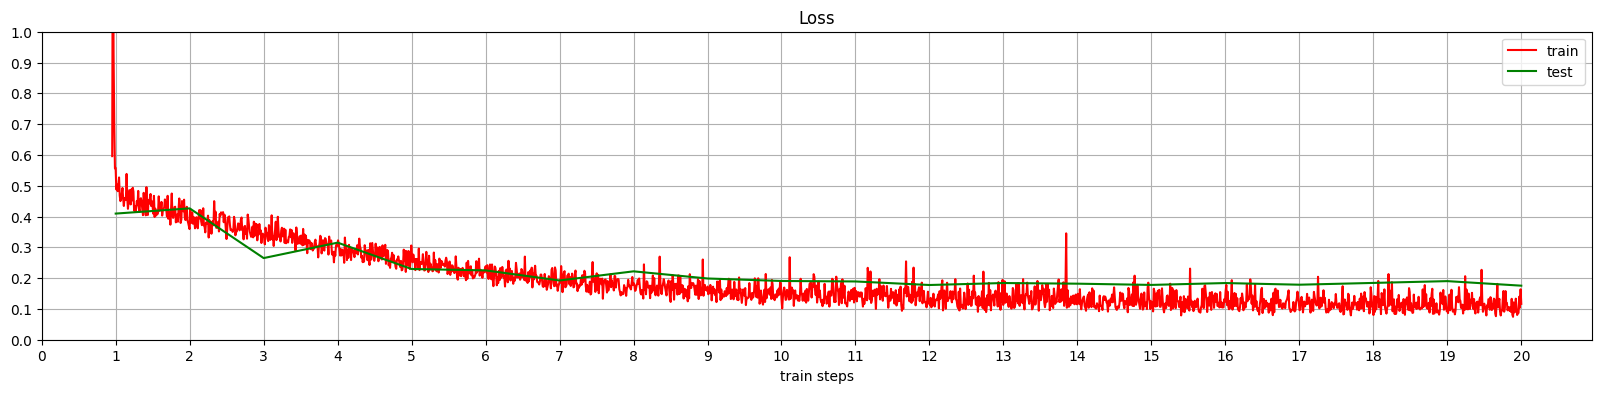

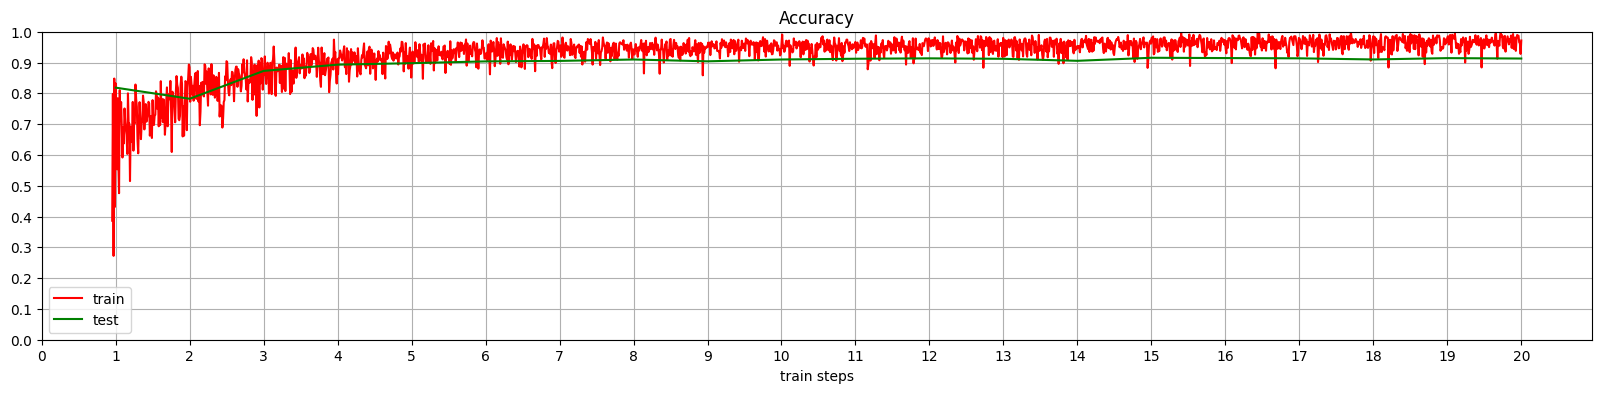

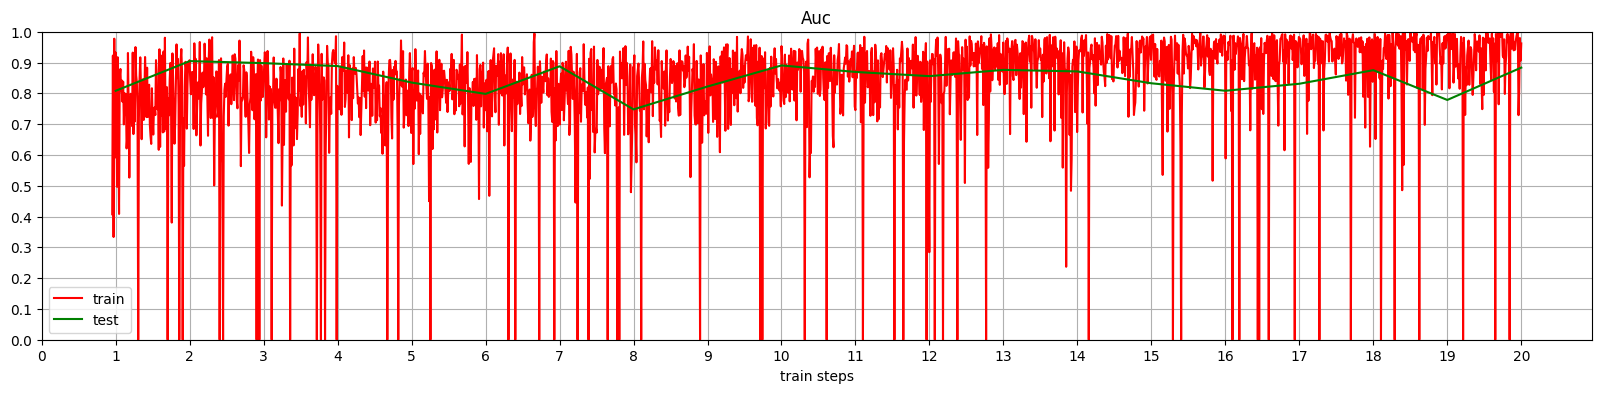

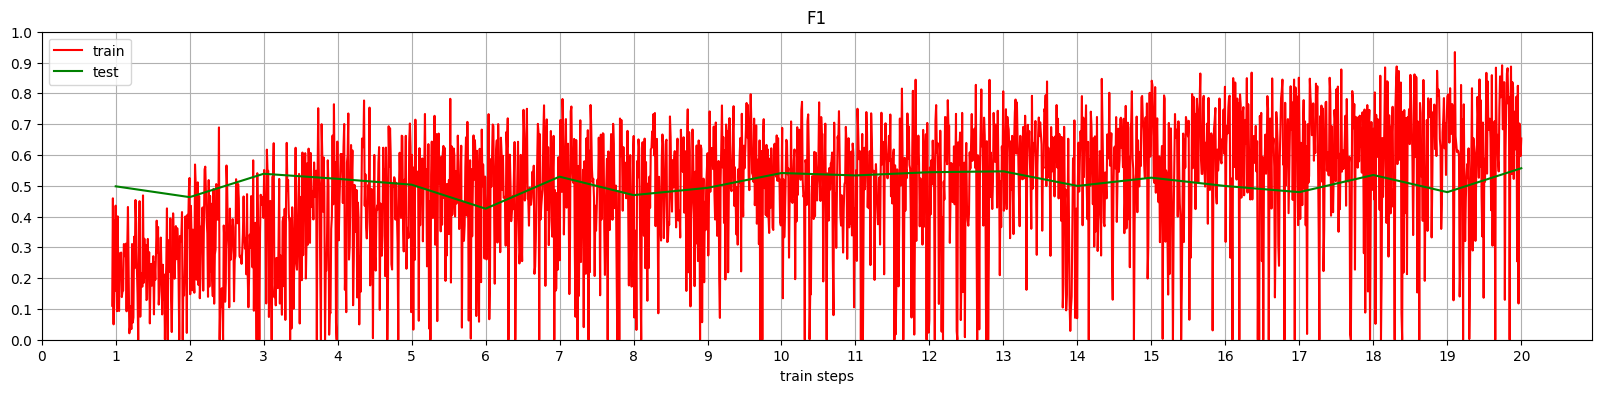

Epoch 20 AUC = 88.35%
Epoch 20 accuracy = 91.30%
Epoch 20 F1 = 55.68%
Final AUC: 0.88
CPU times: user 2h 7min 54s, sys: 40min 2s, total: 2h 47min 56s
Wall time: 2h 48min 27s


In [49]:
%%time
np.random.seed(42)
set_random_seed(42)
small_model = DeepZ().cuda()

opt = torch.optim.RMSprop(small_model.parameters(), lr=10**-4, weight_decay=10**-4)

train_distilation(small_model, teacher_model, opt, 20)